In [3]:
# Import required modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time

In [61]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')

# Separate input features and output feature
X = data.iloc[:, :4].values  
y = data.iloc[:, 4].values  

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [62]:

# # Define the FNN model
# model = Sequential([
#     # Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
#     # Dense(8, activation='relu'),
#     # Dense(1, activation='tanh')  # Output in range [-1, 1]
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='tanh')  # Output in range [-1, 1]
# ])

from tensorflow.keras import layers

# --- Input shapes ---
# Feedforward: e.g., curvature, path slope, future curvature
# Feedback: e.g., heading error, cross track error

# Input layers
feedforward_input = Input(shape=(2,), name="feedforward_input")  # Example: [curvature, lookahead curvature]
feedback_input    = Input(shape=(2,), name="feedback_input")     # Example: [heading error, CTE]

# --- Feedforward block ---
ff = layers.Dense(64, activation='relu')(feedforward_input)
ff = layers.Dense(32, activation='relu')(ff)

# --- Concatenate with feedback ---
combined = layers.Concatenate()([ff, feedback_input])

# --- Final control layers ---
x = layers.Dense(64, activation='relu')(combined)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, name="steering_output", activation='tanh')(x)  # Output: steering angle

# --- Model ---
model = Model(inputs=[feedforward_input, feedback_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# --- Print summary ---
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feedforward_input   │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │        192 │ feedforward_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │      2,080 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feedback_input      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 34)        │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ feedback_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      2,240 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steering_output     │ (None, 1)         │         33 │ dense_27[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,625 (25.88 KB)

 Trainable params: 6,625 (25.88 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Specify callback for logging in-epoch loss
from tensorflow.keras.callbacks import Callback
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Instantiate the callback
batch_loss_logger = BatchLossLogger()

In [67]:
def rmse_loss(y_true, y_pred):
    error = y_pred - y_true
    squared_error = tf.square(error)
    mse = tf.reduce_mean(squared_error)
    rmse = tf.sqrt(mse)
    
    # tf.print("DEBUG — MSE:", mse, "RMSE:", rmse)
    return rmse


In [72]:
def mse_loss(y_true, y_pred):
    error = y_pred - y_true
    squared_error = tf.square(error)
    mse = tf.reduce_mean(squared_error)

    return mse

In [68]:
def rmse_deg_metric(y_true, y_pred):
    # y_true_deg = y_true * 225.0
    # y_pred_deg = y_pred * 225.0
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) * 225

In [73]:
# Start the timer
start_time = time.time()

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[mse_loss, rmse_deg_metric])

# Print the model summary
model.summary()

# Set the inputs
ff_input = X_train[:, [1,3]]
fb_input = X_train[:, [0,2]]

# Train the model
history = model.fit(
    x = {"feedforward_input": ff_input, "feedback_input": fb_input}, 
    y = y_train,
    validation_data=(
    {
        "feedforward_input": X_val[:, [1, 3]],
        "feedback_input": X_val[:, [0, 2]]
    },
    y_val
    ),
    epochs=50,
    batch_size=1024,
    verbose=1,
    callbacks=[batch_loss_logger]
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feedforward_input   │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │        192 │ feedforward_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │      2,080 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feedback_input      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 34)        │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ feedback_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      2,240 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ steering_output     │ (None, 1)         │         33 │ dense_27[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,625 (25.88 KB)

 Trainable params: 6,625 (25.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0011 - mse_loss: 0.1045 - rmse_deg_metric: 72.7256 - val_loss: 0.0011 - val_mse_loss: 0.1053 - val_rmse_deg_metric: 72.9862
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - mse_loss: 0.1046 - rmse_deg_metric: 72.7299 - val_loss: 0.0011 - val_mse_loss: 0.1052 - val_rmse_deg_metric: 72.9532
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - mse_loss: 0.1046 - rmse_deg_metric: 72.7297 - val_loss: 0.0011 - val_mse_loss: 0.1053 - val_rmse_deg_metric: 72.9666
Epoch 4/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - mse_loss: 0.1046 - rmse_deg_metric: 72.7303 - val_loss: 0.0011 - val_mse_loss: 0.1053 - val_rmse_deg_metric: 72.9808
Epoch 5/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - mse_loss: 0.1046 - rmse_deg_metric: 72.7312 - val_loss: 0.0011 - val_mse_loss: 0.1053 - val_rmse_deg_metric: 72.9944
Epoch 6/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - m

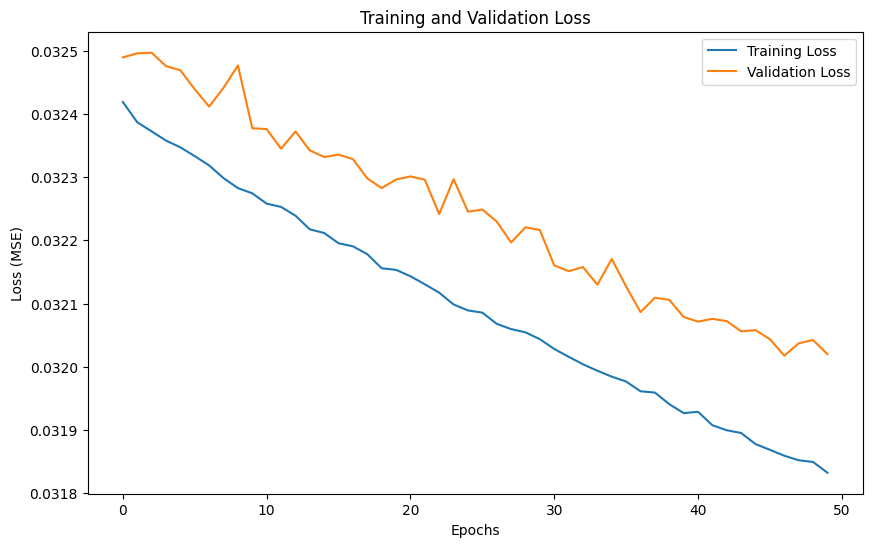

In [74]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
# plt.ylim([0.001, 0.005])
plt.legend()
plt.show()


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


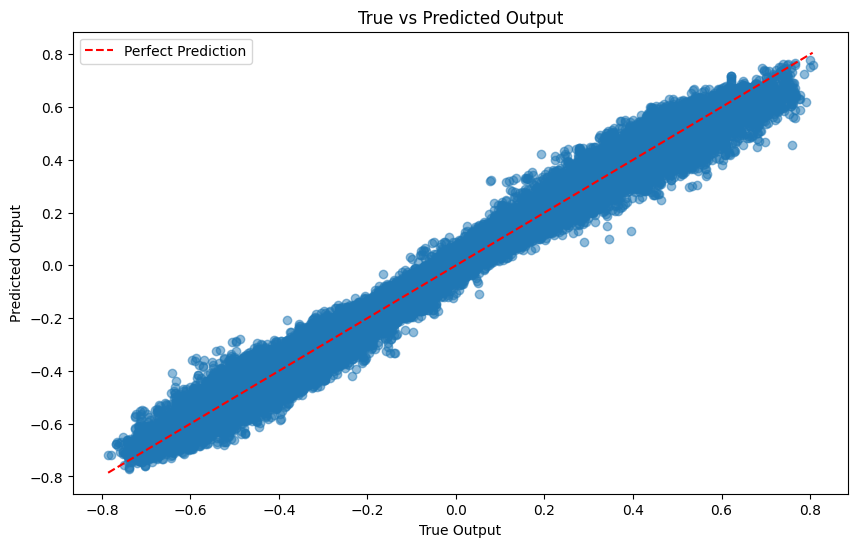

In [75]:
xT = {
        "feedforward_input": X_test[:, [1, 3]],
        "feedback_input": X_test[:, [0, 2]]
    }
# Predict on test set and visualize results
y_pred = model.predict(xT)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Output')
plt.xlabel('True Output')
plt.ylabel('Predicted Output')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

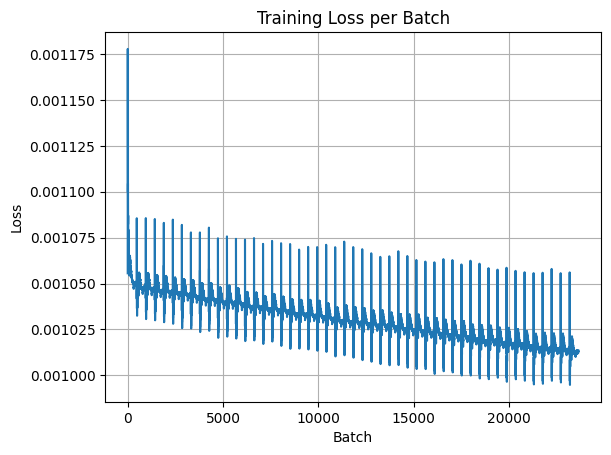

In [76]:
# Plot batch loss
plt.plot(batch_loss_logger.batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.grid(True)
# plt.ylim([0.001, 0.0014])
plt.show()

In [77]:
# Export the model
model.export("SteeringModel_Iteration77")

INFO:tensorflow:Assets written to: SteeringModel_Iteration77\assets


INFO:tensorflow:Assets written to: SteeringModel_Iteration77\assets


Saved artifact at 'SteeringModel_Iteration77'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 2), dtype=tf.float32, name='feedforward_input'), TensorSpec(shape=(None, 2), dtype=tf.float32, name='feedback_input')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2714667276752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714667270992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883120912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883127824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883124176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883119760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714887333712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883119952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883121104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2714883121488: TensorS

In [69]:
# Feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, scoring='neg_mean_absolute_error')
feature_importance = result.importances_mean
print("Feature Importance:", feature_importance)

3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 837us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 840us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 867us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 823us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 888us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 827us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 878us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 818us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 850us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 889us/step
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step
Feature Importance: [0.00890217 0.24059221 0.00758651 0.02045